In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from keras.applications import VGG16
from keras.preprocessing import image_dataset_from_directory

In [4]:
import os
import shutil

# Define the dataset root
dataset_root = "chest_xray/"

# Define paths for NORMAL and PNEUMONIA across train, test, and val
normal_paths = [
    os.path.join(dataset_root, "train/NORMAL/"),
    os.path.join(dataset_root, "test/NORMAL/"),
    os.path.join(dataset_root, "val/NORMAL/"),
]

pneumonia_paths = [
    os.path.join(dataset_root, "train/PNEUMONIA/"),
    os.path.join(dataset_root, "test/PNEUMONIA/"),
    os.path.join(dataset_root, "val/PNEUMONIA/"),
]

# Create a new folder to store combined images
combined_path = os.path.join(dataset_root, "combined")
os.makedirs(combined_path, exist_ok=True)
os.makedirs(os.path.join(combined_path, "NORMAL"), exist_ok=True)
os.makedirs(os.path.join(combined_path, "PNEUMONIA"), exist_ok=True)


In [5]:
def merge_images(source_dirs, dest_dir):
    for source_dir in source_dirs:
        for file_name in os.listdir(source_dir):  # Iterate over all images
            src_file = os.path.join(source_dir, file_name)
            dest_file = os.path.join(dest_dir, file_name)

            # Ensure files are not overwritten by renaming if needed
            if os.path.exists(dest_file):
                base, ext = os.path.splitext(file_name)
                counter = 1
                while os.path.exists(os.path.join(dest_dir, f"{base}_{counter}{ext}")):
                    counter += 1
                dest_file = os.path.join(dest_dir, f"{base}_{counter}{ext}")

            # Copy file to the new location
            shutil.copy(src_file, dest_file)

# Merge NORMAL images
merge_images(normal_paths, os.path.join(combined_path, "NORMAL"))

# Merge PNEUMONIA images
merge_images(pneumonia_paths, os.path.join(combined_path, "PNEUMONIA"))


In [3]:
'''
#Labeling Images
def labeling(directory):
    normal_dir = directory + '/NORMAL/'
    pneumonia_dir = directory + '/PNEUMONIA/'
    normal_images = os.listdir(normal_dir)
    pneumonia_images = os.listdir(pneumonia_dir)
    
    # Create a DataFrame with labels
    df = pd.DataFrame({
        "filename": normal_images + pneumonia_images,
        "label": [0] * len(normal_images) + [1] * len(pneumonia_images)  # 0 for normal, 1 for pneumonia
    })
    
    # Shuffle the dataset
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    return df

train_data = labeling(train_path)
test_data = labeling(test_path)
val_data = labeling(val_path)
'''

'\n#Labeling Images\ndef labeling(directory):\n    normal_dir = directory + \'/NORMAL/\'\n    pneumonia_dir = directory + \'/PNEUMONIA/\'\n    normal_images = os.listdir(normal_dir)\n    pneumonia_images = os.listdir(pneumonia_dir)\n    \n    # Create a DataFrame with labels\n    df = pd.DataFrame({\n        "filename": normal_images + pneumonia_images,\n        "label": [0] * len(normal_images) + [1] * len(pneumonia_images)  # 0 for normal, 1 for pneumonia\n    })\n    \n    # Shuffle the dataset\n    df = df.sample(frac=1, random_state=42).reset_index(drop=True)\n    return df\n\ntrain_data = labeling(train_path)\ntest_data = labeling(test_path)\nval_data = labeling(val_path)\n'

In [18]:
ds_train_ = image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)

ds_test_ = image_dataset_from_directory(
    test_path,
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)

ds_val_ = image_dataset_from_directory(
    val_path,
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [20]:
data = tf.concat([ds_train_, ds_test_], 0)

ValueError: Attempt to convert a value (<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>) with an unsupported type (<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>) to a Tensor.

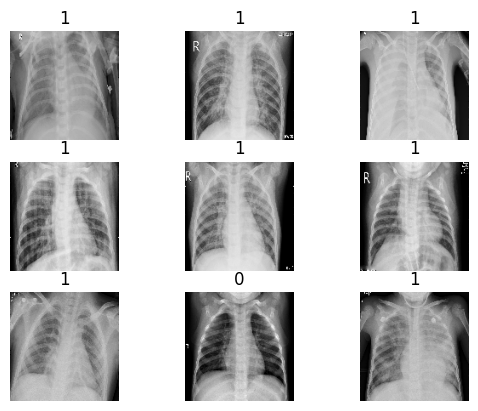

In [11]:
class_names = ds_train_.class_names

for images, labels in ds_train_.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8")) 
        plt.title(int(labels[i]))
        plt.axis("off")

In [14]:
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_test = (
    ds_test_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_val = (
    ds_val_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [13]:
'''
model = keras.Sequential([
    VGG16(include_top=False, pooling='avg'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=30,
)
'''

"\nmodel = keras.Sequential([\n    VGG16(include_top=False, pooling='avg'),\n    layers.Flatten(),\n    layers.Dense(256, activation='relu'),\n    layers.Dense(1, activation='sigmoid'),\n])\n\nmodel.compile(\n    optimizer='adam',\n    loss='binary_crossentropy',\n    metrics=['binary_accuracy'],\n)\n\nhistory = model.fit(\n    ds_train,\n    validation_data=ds_val,\n    epochs=30,\n)\n"